## Import Package

In [1]:
# Import package
import pandas as pd
import numpy as np
import nltk
import re
import string
from  nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from langdetect import detect
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import spacy
# 
import json
from itertools import chain
import os
from pprint import pprint
import matplotlib.pyplot as plt
# LDA
import gensim
from gensim.utils import simple_preprocess
# EDA
from wordcloud import WordCloud
import gensim.corpora as corpora
from pprint import pprint

## Plotting tools
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline
from gensim.models import CoherenceModel

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
gensim.__version__ 

'3.8.3'

## Import Data

In [2]:
# Import data set:
df = pd.read_csv ('../../Data/Reconciliation/USCA_outer.csv')

<ipython-input-2-fbedd7689f8d>:2: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv ('../../Data/Raw_Data/USCA_outer.csv')


## Data Cleaning
#### 1. Cleaning

In [3]:
txt = df["Description"]
txt[txt == "[MT]"] = ""
txt[txt == "[OS]"] = ""

/var/folders/qb/zk_1sfdx3psf0kn4pmydt0b40000gn/T/ipykernel_50998/3552666939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txt[txt == "[MT]"] = ""
/var/folders/qb/zk_1sfdx3psf0kn4pmydt0b40000gn/T/ipykernel_50998/3552666939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txt[txt == "[OS]"] = ""


#### 2. Meaningless Phrase Removal

In [4]:
# Function for Remove Meaningless Phrase:
def asterisk_remover(txt):
    x = re.search("^\*{3}.+\*{3}",txt)
    if x != None:
        txt = txt[x.end():]
    return txt
def slash_remover(txt):
    x = re.search("^\/{3}.+\/{3}",txt)
    if x != None:
        txt = txt[x.end():]
    return txt
def from_remover(txt):
    x = re.search("^Form filled and submitted by <redacted>.+renseignements|Surveillance and Information Division|SURVEILLANCE AND INFORMATION DIVISION|Surveillance & Information Division|Surveillance and Information|\[DIVISION\]|^Form.+\/{3}|Form filled and submitted by <redacted>",txt)
    if x != None:
        txt = txt[x.end():]
    return txt
# We only care about cases in north America, remove case in US to prevent duplication
def foreign(txt):
    x = re.search("Foreign Incident|Foreign Case",txt)
    if x != None:
        txt = ""
    return txt

# Remove meaningless txt
for i in range(len(txt)):
    txt[i] = asterisk_remover(txt[i])
    txt[i] = slash_remover(txt[i])
    txt[i] = from_remover(txt[i])
    txt[i] = foreign(txt[i])

/var/folders/qb/zk_1sfdx3psf0kn4pmydt0b40000gn/T/ipykernel_50998/1033682924.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txt[i] = asterisk_remover(txt[i])
/var/folders/qb/zk_1sfdx3psf0kn4pmydt0b40000gn/T/ipykernel_50998/1033682924.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txt[i] = slash_remover(txt[i])
/var/folders/qb/zk_1sfdx3psf0kn4pmydt0b40000gn/T/ipykernel_50998/1033682924.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

#### 3. Space and Pattern Removal

In [5]:
# Remove Special Character and lowercase
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt   

spec_chars = ["RT @[_A-Za-z0-9]+:","!",'"',"%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]

for i in range(len(txt)):
    for char in spec_chars:
        txt[i] = txt[i].replace(char, ' ')
        txt[i] = txt[i].lower()
        
# Remove Duplicated Space
def space_remover(txt):
    txt = re.sub("\s+"," ",txt)
    if re.search("^\s",txt) != None:
        txt = txt[re.search("^\s",txt).end():]
    if re.search("\s$",txt) != None:
        txt = txt[:re.search("\s$",txt).start()]
    return txt
for i in range(len(txt)):
    txt[i] = space_remover(txt[i])  

/var/folders/qb/zk_1sfdx3psf0kn4pmydt0b40000gn/T/ipykernel_50998/1930119093.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txt[i] = txt[i].replace(char, ' ')
/var/folders/qb/zk_1sfdx3psf0kn4pmydt0b40000gn/T/ipykernel_50998/1930119093.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txt[i] = txt[i].lower()
/var/folders/qb/zk_1sfdx3psf0kn4pmydt0b40000gn/T/ipykernel_50998/1930119093.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

#### 4. Number and French Removal

In [6]:
# Function for remove number:
def remove_number(txt):
    x = re.search("^[0-9]+$",txt)
    if x != None:
        txt = ''
    return txt


##= Remove number and French:
count = 0
for i in range(len(txt)):
    txt[i] = remove_number(txt[i])
    a = txt[i]
    if a != "":
        if detect(a) == "fr":
            count += 1
            txt[i] = ""
print(count)

/var/folders/qb/zk_1sfdx3psf0kn4pmydt0b40000gn/T/ipykernel_50998/1006240585.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txt[i] = remove_number(txt[i])
/var/folders/qb/zk_1sfdx3psf0kn4pmydt0b40000gn/T/ipykernel_50998/1006240585.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  txt[i] = ""


2268


---
## Pre processing
* Tokenize words
* Remove Stopping words
* Lemmatize narrative

#### 1. Tokenize words & Clean-up text

In [ ]:
listOfText_p1=list(txt)
# convert sentence to words
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
# convert
data_words = list(sent_to_words(listOfText_p1))
print(data_words[:1])

[['on', 'vacation', 'use', 'the', 'banana', 'boat', 'product', 'sunscreen', 'and', 'days', 'later', 'he', 'broke', 'out', 'on', 'rash', 'that', 'turned', 'into', 'blister', 'like']]


#### 2. Lemmatize narrative

In [10]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    #"""https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized  = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# (try to remove adv and adj)

In [11]:
print(data_lemmatized[0])
print(type(data_lemmatized))

['vacation', 'use', 'banana', 'boat', 'product', 'sunscreen', 'day', 'later', 'break', 'rash', 'turn', 'blister']
<class 'list'>


#### 3. Creating Bigram and Trigram Models

Aim to identify phrase

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_lemmatized, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_lemmatized], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_lemmatized[0]]])

['vacation', 'use', 'banana_boat', 'product', 'sunscreen', 'day', 'later', 'break', 'rash', 'turn', 'blister']


#### 4. Make Trigram


In [13]:
# functions:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# detect vocabulary
data_words_trigrams = make_trigrams(data_lemmatized)

# Show type
print(type(data_words_trigrams))

<class 'list'>


#### 5. Remove Stopping words

In [ ]:
# Remove stopping words:
stop_words = stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data_words_NS = remove_stopwords(data_words_trigrams)
print(data_words_NS[0])

['vacation', 'use', 'banana_boat', 'product', 'sunscreen', 'day', 'later', 'break', 'rash', 'turn', 'blister']


#### 6. Example

In [ ]:
# Example of post process narrative
ind = 214694
print("Before:")
print(df["INCIDENT.DESCRIPTION"][ind])
print("\n")
print("Token:")
print(data_words[ind])
print("\n")
print("Lemmatized:")
print(data_lemmatized[ind])
print("\n")
print("Trigram:")
print(data_words_trigrams[ind])
print("\n")
print("Remove Stop_word:")
print(data_words_NS[ind])

Before:
CONSUMER HAS A SAFETY ISSUE WITH THREE PHOTOS OF A PRODUCT WHICH HAS LITERALLY EXPLODED WITH THE COLD WEATHER. CONSUMER BELIEVES THIS PRODUCT POSES A HAZARD WHEN EXPOSED TO FREEZING CONDITIONS.


Token:
['consumer', 'has', 'safety', 'issue', 'with', 'three', 'photos', 'of', 'product', 'which', 'has', 'literally', 'exploded', 'with', 'the', 'cold', 'weather', 'consumer', 'believes', 'this', 'product', 'poses', 'hazard', 'when', 'exposed', 'to', 'freezing', 'conditions']


Lemmatized:
['consumer', 'safety', 'issue', 'photo', 'product', 'literally', 'explode', 'cold', 'weather', 'consumer', 'believe', 'product', 'pose', 'hazard', 'expose', 'freeze', 'condition']


Trigram:
['consumer', 'safety', 'issue', 'photo', 'product', 'literally', 'explode', 'cold_weather', 'consumer', 'believe', 'product', 'pose', 'hazard', 'expose', 'freeze', 'condition']


Remove Stop_word:
['consumer', 'safety', 'issue', 'photo', 'product', 'literally', 'explode', 'cold_weather', 'consumer', 'believe', '

#### 7. EDA

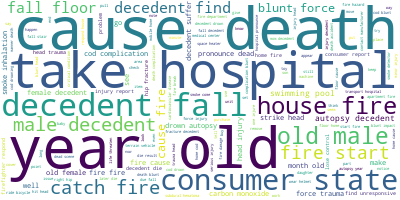

In [19]:
# Join the diffeerent narrative together
','.join(data_lemmatized[0])
temp = []
for sent in data_lemmatized:
    temp.append(','.join(sent))

long_string = ','.join(temp)

# Create a WorldCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

#### 9. Remove additional words from the narrative

Import self designed stop word list

In [ ]:
# Import stop word list
colnames=['vocab', 'count', 'percentage', 'remove',"sec"] 
word_list = pd.read_csv ('../Data/word_list.csv', names=colnames, header=None)
word_list = word_list[:500]
add_stop = list(word_list[word_list["remove"] == "1"]["vocab"])
print(len(add_stop))
# remove additional stop words
stop_words.extend(add_stop)
clean_data = remove_stopwords(data_words_NS)

160

#### View

In [22]:
ind = 214694
print("Before:")
print(df["INCIDENT.DESCRIPTION"][ind])
print("\n")
print("Token:")
print(data_words[ind])
print("\n")
print("Lemmatized:")
print(data_lemmatized[ind])
print("\n")
print("Trigram:")
print(data_words_trigrams[ind])
print("\n")
print("Remove Stop_word:")
print(data_words_NS[ind])
print('\n')
print("Additional Stop_word:")
print(clean_data[ind])

Before:
CONSUMER HAS A SAFETY ISSUE WITH THREE PHOTOS OF A PRODUCT WHICH HAS LITERALLY EXPLODED WITH THE COLD WEATHER. CONSUMER BELIEVES THIS PRODUCT POSES A HAZARD WHEN EXPOSED TO FREEZING CONDITIONS.


Token:
['consumer', 'has', 'safety', 'issue', 'with', 'three', 'photos', 'of', 'product', 'which', 'has', 'literally', 'exploded', 'with', 'the', 'cold', 'weather', 'consumer', 'believes', 'this', 'product', 'poses', 'hazard', 'when', 'exposed', 'to', 'freezing', 'conditions']


Lemmatized:
['consumer', 'safety', 'issue', 'photo', 'product', 'literally', 'explode', 'cold', 'weather', 'consumer', 'believe', 'product', 'pose', 'hazard', 'expose', 'freeze', 'condition']


Trigram:
['consumer', 'safety', 'issue', 'photo', 'product', 'literally', 'explode', 'cold_weather', 'consumer', 'believe', 'product', 'pose', 'hazard', 'expose', 'freeze', 'condition']


Remove Stop_word:
['consumer', 'safety', 'issue', 'photo', 'product', 'literally', 'explode', 'cold_weather', 'consumer', 'believe', '

In [ ]:
## Triagram
listOfText_p2 = []
for i in range(len(clean_data)):
    listOfText_p2.append(" ".join(clean_data[i]))
#text_list
## Biagram
listOfText_p3 = []
for i in range(len(data_words)):
    listOfText_p3.append(" ".join(data_words[i]))

## Add Year Column (Dynamic Modeling)

In [ ]:
df["Year"] = np.nan
temp = df["Year"]

a = 0
b = 0
for i in range(len(df)):
    if pd.isna(df.iloc[i]["RECEIVED.YEAR"]) == False:
        temp[i] = int(df.iloc[i]["RECEIVED.YEAR"])
        a += 1
    elif pd.isna(df.iloc[i]["Case.Number"]) == False:
        temp[i] = int(df.iloc[i]["Case.Number"][0:4])
        b += 1 

## Output clean data file

In [32]:
df["clean_text"]=listOfText_p2
df["raw_text"]=listOfText_p3
import openpyxl
#df.to_excel("../Data/USCA.xlsx", header = True, index = False)